In [2]:
using JuMP, Gurobi, Random

In [3]:
using JuMP, Gurobi, StatsBase, DataFrames, CSV, LinearAlgebra, Distributions, Random
const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2022-07-20


Gurobi.Env(Ptr{Nothing} @0x00007f90fa750600, false, 0)

In [57]:
#using Dualization

┌ Info: Precompiling Dualization [191a621a-6537-11e9-281d-650236a99e60]
└ @ Base loading.jl:1278


In [4]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

solve_model (generic function with 1 method)

In [213]:
function solve_model_benders(m)
    "Solve the Benders master problem
    "
    optimize!(m)
    U_OA = objective_value(m)
    #println("U_OA from solve ", U_OA)
    return value.(m[:β]), value.(m[:α]), U_OA
end

solve_model_benders (generic function with 1 method)

In [214]:
function get_Y(X, t)
    "
    Create the vector of data for the dual problem
    "
    T, p = size(X)
    Y = zeros(1,T*p)
    Y[(t-1)*p+1:t*p] = X[t,:]
    return Y
end

function get_Z(X)
    T, p = size(X)
    Z = zeros(T, T*p)
    for t=1:T
        Z[t,:] = get_Y(X,t)
    end
    return Z
end

function get_A(X, t)
    T, p = size(X)
    A = zeros(p,T*p)
    A[:,(t-1)*p+1:t*p] = 1 * Matrix(I, p, p)
    return A
end

get_A (generic function with 1 method)

In [168]:
function S_dual(X, y, β0, epsilon, delta)
    
    #Dual problem
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return objective_value(model), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

S_dual (generic function with 1 method)

In [169]:
function R(X, D_min, D_max, β0, epsilon, delta) 
    "
    Full dual problem
    "
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
       
    # Add objective
    @objective(model, Max, 2*dot(λ[1,:],y) - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)) #
    optimize!(model)
    return objective_value(model), getvalue.(y), getvalue.(λ), getvalue.(ν), getvalue.(μ)
end

R (generic function with 1 method)

In [229]:
function master_problem(X0, Xt, y0, D_min, D_max, threshold = 0.1, epsilon = 0.1, delta = 0.1, reg = 1, ρ = 1, max_cuts = 10, verbose=0)
    n, p = size(X0)
    T, p = size(Xt)
    #Z = get_Z(X0)
    L_BD = -10000
    U_BD = 10000
    cuts = 0
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, α)
    @variable(model, β[j=1:p])
    
    #Warm start for β
    β_val0 = l2_regression(X0, y0, ρ)#Random.rand(p)#
    
    #Initialization
    _, y_val0, λ_val0, ν_val0, μ_val0 = R(Xt, D_min, D_max, β_val0, epsilon, delta)
    
    #First constraint
    @constraint(model, α >= 2*dot(λ_val0[1,:],y_val0) - sum(y_val0)
                            - delta * sum(sum(ν_val0[1,t,i]+ν_val0[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val0[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val0[2,t,:]) for t = 1:T))
       
    # Add objective
    @objective(model, Min, 1/n*sum((y0[i]-sum(X0[i,j]*β[j] for j=1:p))^2 for i=1:n) + reg*α + ρ*sum(β[j]^2 for j=1:p))
    
    while cuts < max_cuts && U_BD - L_BD > threshold
        if verbose
            println("Lower: ", L_BD, " Upper: ", U_BD)
        end
        cuts += 1
        
        #Solve current Master Problem
        β_val, α_val, L_BD = solve_model_benders(model)
        U_OA, y_val, λ_val, ν_val, μ_val = R(Xt, D_min, D_max, β_val, epsilon, delta)
        
        U_BD = 1/n*sum((y0[i]-sum(X0[i,j]*β_val[j] for j=1:p))^2 for i=1:n) + reg*U_OA + ρ*sum(β_val[j]^2 for j=1:p)
        
        if U_BD - L_BD > threshold
            @constraint(model, α >= 2*dot(λ_val[1,:],y_val) - sum(y_val)
                            - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β, μ_val[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β, μ_val[2,t,:]) for t = 1:T))
            if verbose                    
                println("Cut added")
            end
        end
    end
    optimize!(model)
    println("Final model Obj value: ", objective_value(model))
    println("Lower: ", L_BD, " Upper: ", U_BD)
    return objective_value(model), getvalue.(β)#, getvalue.(λ), getvalue.(ν), getvalue.(μ)
end    

master_problem (generic function with 8 methods)

In [261]:
X_test_adaptive = CSV.read("traffic_predictions_test_val.csv", DataFrame)
select!(X_test_adaptive, Not([:DummyRegressor,:Lasso, :LassoLars]))#, index = 'Unnamed: 0')
y_test = CSV.read("traffic_test_val_scaled.csv", DataFrame)#, index = 'Unnamed: 0')
n0 = 1000
n = 100
m = 1
X = X_test_adaptive[!,1:25]
y = y_test[!, "target"];
X0 = Matrix(X[n0:n0+n,:])
X0[:,1] = ones(n+1)
y0 = y[n0:n0+n,:][:]

yt_true = y[n0+n+1:n0+n+m,:][:]
Xt = Matrix(X[n0+n+1:n0+n+m,:])
Xt[:,1] = ones(m)
yt = mean(Xt, dims = 2)#y[n0+n+1:n0+n+m,:][:]
epsilon = 0.02
delta = 0.02
threshold = 1e-8
reg = 1;

#X_test_adaptive = X_test_adaptive.drop(columns = ['DummyRegressor', 'Lasso', 'LassoLars'])

In [248]:
function prepare_data(X, y, n0, n, m, std_factor)
    
    X0 = Matrix(X[n0:n0+n,:])
    X0[:,1] = ones(n+1)
    y0 = y[n0:n0+n,:][:]

    yt_true = y[n0+n+1:n0+n+m,:][:]
    Xt = Matrix(X[n0+n+1:n0+n+m,:])
    Xt[:,1] = ones(m)
    yt = mean(Xt, dims = 2)
    
    D_min = yt .- std_factor*std(Xt, dims = 2)
    D_max = yt .+ std_factor*std(Xt, dims = 2)
    
    return X0, y0, Xt, yt, D_min, D_max
end

prepare_data (generic function with 1 method)

In [250]:
X0, y0, Xt, yt, D_min, D_max = prepare_data(X, y, 100, 48, 1, 1)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07759754048386233
Final model Obj value: 0.07759735933952205
Lower: 0.07759735933952205 Upper: 0.07759735933952507


(0.07759735933952205, [0.013871854943931805, 0.031293871271905194, 0.07106006532010122, 0.03647952011654193, 0.06931602877864938, 0.0072246867680013154, 0.03520176495824233, 0.07527454339033478, 0.07151400185881655, 0.020118222304224494  …  0.0355365911933577, 0.03527296619937535, 0.03401624322047278, 0.029531018390049967, 0.036128995009860575, 0.035957707916955996, 0.03708007693672764, 0.036679083125609094, 0.020118222304212, 0.07053376854010016])

In [251]:
X0, y0, Xt, yt, D_min, D_max = prepare_data(X, y, 101, 48, 1, 1)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07777306173873602
Final model Obj value: 0.07777277079080891
Lower: 0.07777277079080891 Upper: 0.0777727707907998


(0.07777277079080891, [0.014677044466902094, 0.030971147582727277, 0.07115352892512324, 0.03653975823512827, 0.06949316420576948, 0.007249288284493722, 0.03525075992106974, 0.07530738631806436, 0.07151946287004485, 0.020686319200357666  …  0.03558191039342365, 0.03531346016119178, 0.034034068193248446, 0.02943112134633463, 0.036178342997065266, 0.036013486222267466, 0.03713772307778912, 0.03673822246001721, 0.020686319200355338, 0.07069790977571708])

In [252]:
X0, y0, Xt, yt, D_min, D_max = prepare_data(X, y, 102, 48, 1, 1)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07846264898117644
Final model Obj value: 0.07846262737415821
Lower: 0.07846262737415821 Upper: 0.0784626273741527


(0.07846262737415821, [0.013598957661381826, 0.03171747216186609, 0.07131776865039711, 0.036170861524129634, 0.06918937906362566, 0.007240136462765787, 0.03490185740751056, 0.07557240854168013, 0.07173735508413721, 0.020215293605156167  …  0.035230377675337515, 0.03497629266256038, 0.03378163067580022, 0.029365904562165226, 0.03580243994594172, 0.03562974906506159, 0.03676897675548446, 0.03636828447345122, 0.020215293605152566, 0.07102018581646732])

In [259]:
function build_beta(X, y, n0, n, m, std_factor, steps)
    p = size(X)[2]
    β_list = zeros(steps, p)
    for s=1:steps
        X0, y0, Xt, yt, D_min, D_max = prepare_data(X, y, n0+s, n, m, std_factor)
        obj, β = master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)
        β_list[s,:] = β
    end
    return β_list
end

build_beta (generic function with 1 method)

In [282]:
β_list = build_beta(X,y,1000,3,1,0.5,50)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.17678775118403384
Final model Obj value: 0.1767872974899367
Lower: 0.1767872974899367 Upper: 0.17678729748993643
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.13075599007301014
Final model Obj value: 0.13075585689199842
Lower: 0.13075585689199842 Upper: 0.13075585689199343
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.12714497284627793
Final model Obj value: 0.1271446049595617
Lower: 0.1271446049595617 Upper: 0.1271446049595239
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.09130690729345065
Final model Obj value: 0.0913067873698079
Lower: 0.0913067873698079 Upper: 0.09130678736980788
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.10258651992052309
Final model Obj value: 0.10258627333319659
Lower: 0.10258627333319659 Upper: 0.10258627333319008
Academic license - for non-commercial use only - expires 2022-

Final model Obj value: 0.045709195636543326
Lower: 0.045709195636543326 Upper: 0.04570919361239724
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07072991757021195
Final model Obj value: 0.07072977952027368
Lower: 0.07072977952027368 Upper: 0.07072977952027332
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.07928299438894329
Final model Obj value: 0.07928250496656125
Lower: 0.07928250496656125 Upper: 0.07928250496656201
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.10371535507340668
Final model Obj value: 0.10992928131061708
Lower: 0.10992928131061708 Upper: 0.10992928126598103
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.10390384503189015
Final model Obj value: 0.12230938418656057
Lower: 0.12230938418656057 Upper: 0.12230938418479935
Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.08930481771051452
Final model Obj value: 0.10234808097984738
Lower: 0.1

50×25 Array{Float64,2}:
 -0.00901722   0.0128371   0.0725933  …  0.00439653  0.0283151    0.0917659
  0.0388874    0.0182138   0.0860287     0.00690201  0.009431     0.0829059
  0.0956687    0.0367704   0.101198      0.00957185  0.03065      0.103795
  0.0522433    0.0238422   0.0656542     0.0326161   0.0360279    0.0544601
  0.0429721    0.0359026   0.0663926     0.0304805   0.013401     0.0529684
  0.0353997    0.0351328   0.0680139  …  0.0305594   0.00622853   0.0536762
  0.030162     0.0342177   0.0337154     0.0344374   0.0236998    0.0331107
  0.0436805    0.0181207   0.0292767     0.0285317   0.0365182    0.0281481
  0.0442888    0.0184294   0.0300628     0.0316146   0.0387196    0.0284406
  0.0431871    0.0185898   0.0352254     0.0334934   0.0384213    0.0331581
  0.0430052    0.0205949   0.0415171  …  0.0362833   0.0354887    0.0448324
  0.0388159    0.0208901   0.0578486     0.0405223   0.0263171    0.0583788
  0.0443612    0.02239     0.0558603     0.0430831   0.0332264   

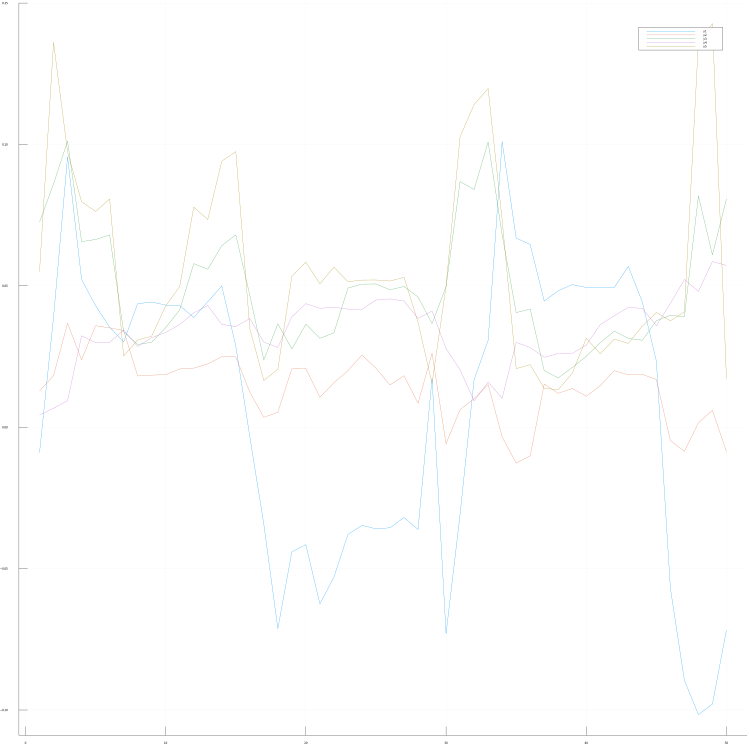

In [283]:
using Plots
plot(β_list[:,1:5])
plot!(size=(3000,3000))

In [247]:
l2_regression(X0, y0, 1)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.18399418080711155


25-element Array{Float64,1}:
 -0.09283845126159099
  0.015895901472356765
  0.05606764858457942
  0.04745812208357671
  0.062078742203801114
  0.012506540976888011
  0.049148017408009614
  0.06335348106834261
  0.06043453377714183
  0.0008716707504832354
  0.05071250601555667
  0.09016311752471651
  0.06200236484039327
  0.047793781297676655
  0.06057484242771264
  0.049264369636408595
  0.05010659602757768
  0.05098262934784549
  0.054615943878114165
  0.047094450509387195
  0.0474131104149189
  0.04779378129740781
  0.047601201520920844
  0.0008716707504830129
  0.05706550297049887

In [243]:
D_min = yt .- 0.5*std(Xt, dims = 2)
D_max = yt .+ 0.5*std(Xt, dims = 2)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.18399418080711155
Final model Obj value: 0.18399409230277075
Lower: 0.18399409230277075 Upper: 0.1839940923027802


(0.18399409230277075, [-0.09285356359882664, 0.015895317253804265, 0.05607450837493331, 0.04746500972307322, 0.062092944551477895, 0.012509790363913377, 0.04915507015322633, 0.06335670173823967, 0.06044136796636821, 0.0008768227554072206  …  0.04927137215464978, 0.05011363553835622, 0.05098989846149187, 0.054624994136901084, 0.047101245261787425, 0.04741993053116138, 0.047800615459012645, 0.04760806781536683, 0.0008768227554002326, 0.057076728901269635])

In [241]:
D_min = yt .- std(Xt, dims = 2)
D_max = yt .+ std(Xt, dims = 2)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.18399418080711155
Final model Obj value: 0.18399409230277075
Lower: 0.18399409230277075 Upper: 0.1839940923027802


(0.18399409230277075, [-0.09285356359882664, 0.015895317253804265, 0.05607450837493331, 0.04746500972307322, 0.062092944551477895, 0.012509790363913377, 0.04915507015322633, 0.06335670173823967, 0.06044136796636821, 0.0008768227554072206  …  0.04927137215464978, 0.05011363553835622, 0.05098989846149187, 0.054624994136901084, 0.047101245261787425, 0.04741993053116138, 0.047800615459012645, 0.04760806781536683, 0.0008768227554002326, 0.057076728901269635])

In [242]:
D_min = yt .- 2*std(Xt, dims = 2)
D_max = yt .+ 2*std(Xt, dims = 2)
master_problem(X0, Xt, y0, D_min, D_max, threshold, epsilon, delta, reg, 1, 20, false)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.18399418080711155
Final model Obj value: 0.22818761001495758
Lower: 0.22818761001495758 Upper: 0.22818760357384368


(0.22818761001495758, [-0.06919826820286266, -0.013052254968335534, 0.03225440293143466, 0.03149065075320326, 0.09800993558257123, 0.017956956895179243, 0.034905002031440244, 0.09011455885303575, 0.060859644651736836, 0.08238500587189423  …  0.03304780298327493, 0.03431657870051667, 0.03895969633785862, 0.020800365423623634, 0.02688624665802083, 0.027652899285526018, 0.029906419250566963, 0.030714633550219188, 0.08238500587189496, 0.0432882140728421])

In [607]:
println(mean(Xt, dims = 2))
println(yt_true)
println(std(Xt, dims = 2))

[0.10766507853351705; -0.13668422095743302; -0.3006446204596253]
[0.03421517055276293, -0.2780628119042752, -0.36395166876447804]
[0.08064001686133855; 0.11168116074774385; 0.12998088602595428]


In [222]:
l2_regression(X0, y0, 1)

Academic license - for non-commercial use only - expires 2022-07-20
Obj 0.18399418080711155


25-element Array{Float64,1}:
 -0.09283845126159099
  0.015895901472356765
  0.05606764858457942
  0.04745812208357671
  0.062078742203801114
  0.012506540976888011
  0.049148017408009614
  0.06335348106834261
  0.06043453377714183
  0.0008716707504832354
  0.05071250601555667
  0.09016311752471651
  0.06200236484039327
  0.047793781297676655
  0.06057484242771264
  0.049264369636408595
  0.05010659602757768
  0.05098262934784549
  0.054615943878114165
  0.047094450509387195
  0.0474131104149189
  0.04779378129740781
  0.047601201520920844
  0.0008716707504830129
  0.05706550297049887

In [207]:
function l2_regression(X, y, rho; solver_output=0)
    n,p = size(X)
    
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", solver_output) 
    
    @variable(model,beta[j=1:p])
    @variable(model, sse>=0)
    @variable(model, reg>=0)
    @constraint(model, sum((y[i]-sum(X[i,j]*beta[j] for j=1:p))^2 for i=1:n) <= sse)
    @constraint(model, sum(beta[j]^2 for j=1:p)<=reg)
    @objective(model,Min, 1/n*sse + rho*reg)
    
    optimize!(model)
    println("Obj ", objective_value(model))
    return (value.(beta))
end

l2_regression (generic function with 1 method)

In [358]:
n0 = 10000
nt = 6
p = 2
X0 = Random.rand(n0,p)
Xt = Random.rand(nt,p)
#X[:,-1] = np.ones(n)
y0 = Random.rand(n0)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(nt)
D_max = D_min .+ 0.5 
threshold = 0.1

master_problem(X0, Xt, y0, D_min, D_max)

Lower: -10000 Upper: 10000
U_OA from solve 1198.2766764537887
Cut added
Lower: 1198.2766764537887 Upper: 1198.5123856699468
U_OA from solve 1198.8754197421135


(1198.8754197421135, [0.42564886048603606, 0.4264470845984377])

# Old

In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

In [269]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) + dot(λ[1,:].-λ_val0[1,:], y_val0) + dot(y.-y_val0,λ_val0[1,:]))
    
    # Add objective
    @objective(model, Max, 2*α - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
                                
            println("Cut added")
            println(y_val)
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 6.89489784982016 Upper: 10000
U_OA from solve 9.50676896820302
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
[0.44910485812064715, 1.1859076466511875, 0.5476733628913486, 0.2109752836052723, 1.378041767950016, 0.374536996965517, 0.7251971752451791, 1.3691365132789919, 0.9392487930236328, 0.4227048487390981, 0.7371619945268744, 0.012081208078308148, 1.0276201350204741, 1.2833686214418156, 0.5861331896665185, 1.0650113029593455, 0.232469029952036, 1.3379676792557893, 1.4596243879928867, 1.2411937998506408]
Lower: 9.695786571685225 Upper: 9.50676896820302
U_OA from solve 9.50676896820302
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
[0.44910485812064715, 1.1859076466511875, 0.5476733628913486, 0.2109752836052723, 1.378041767950016, 0.374536996965517, 0.7251971752451791, 1.3691365132789919, 0.9392487930236328, 0.4227048487390981, 0.7371619945268744, 0.0

In [273]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "NonConvex", 2)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = D_max #(D_min .+ D_max)./2
    L_OA, λ_val0, ν_val0, μ_val0 = S_dual(X, y_val0, β0, epsilon, delta)
    
    # Add objective
    @objective(model, Max, 2*transpose(λ[1,:])*y - sum(y)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 6.139199513343522 Upper: 10000
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2850 rows, 680 columns and 4780 nonzeros
Model fingerprint: 0x505479be
Model has 30 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-04, 1e+00]
  Objective range  [5e-02, 1e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+00]
Presolve removed 2700 rows and 30 columns

Continuous model is non-convex -- solving as a MIP.

Presolve removed 2700 rows and 180 columns
Presolve time: 0.00s
Presolved: 180 rows, 530 columns, 970 nonzeros
Variable types: 500 continuous, 30 integer (30 binary)

Root relaxation: objective 1.246047e+01, 284 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [271]:
n = 30
p = 5
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2852 rows, 682 columns and 4883 nonzeros
Model fingerprint: 0x6bebc612
Coefficient statistics:
  Matrix range     [7e-04, 1e+00]
  Objective range  [5e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+01]
Presolve removed 2702 rows and 64 columns
Presolve time: 0.00s
Presolved: 150 rows, 618 columns, 1020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8856406e+01   7.312947e+01   0.000000e+00      0s
     298    1.0856114e+01   0.000000e+00   0.000000e+00      0s

Solved in 298 iterations and 0.01 seconds
Optimal objective  1.085611376e+01

User-callback calls 335, time in user-callback 0.00 sec
10000
4.960473282817949


30-element Array{Float64,1}:
 0.5191025477750704
 1.0050811033004208
 1.2099690485313632
 0.36189749029161034
 0.49893452500354263
 1.434251960631498
 1.3668963479536342
 1.2192586265507033
 0.22981764003633476
 1.3456953427792637
 1.1108493801344979
 0.33660946997334595
 0.05328918028719687
 ⋮
 0.16907880592122382
 0.1746445234450209
 0.7694805310968174
 0.8904179931067624
 1.1270924027059324
 1.3122967540717276
 1.489353226313489
 0.431520488325551
 0.19245588276446846
 1.41857722740096
 0.6543399906901304
 0.1498326677365096

In [173]:
sub_OA = U_OA - getvalue.(α)

-2.1744458297540286

In [174]:
sub_LA = L_OA - dot(λ_val[1,:],y_val) + dot(λ_val[2,:],y_val) 

-1.7376516923119785

In [ ]:
2*α - sum(y[t] for t=1:T)
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T)

In [176]:
dot(λ_val[1,:],y_val) - dot(λ_val[2,:],y_val)

4.763530849986924

In [175]:
2*getvalue.(α)-sum(getvalue.(y))

4.622827386255075

In [185]:
λ_val = getvalue.(λ)

2×8 Array{Float64,2}:
 0.237489  1.0  1.0  1.0  1.0  1.0  0.0  0.5
 0.762511  0.0  0.0  0.0  0.0  0.0  1.0  0.5

In [240]:
y_val = getvalue.(y)

10-element Array{Float64,1}:
 1.246619713529564
 0.2357621500647733
 0.8031199904871795
 0.8234069949557103
 0.6149510694043452
 0.02696144751072249
 0.01934453317589746
 0.6189572592935506
 1.4168534654101108
 0.027498555784792655

In [ ]:
dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])

In [234]:
dot(λ_val0[1,:],y_val0) + dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

5.322916405478342

In [235]:
dot(λ_valu[1,:],y_val) #+ dot(λ_valu[1,:].-λ_val0[1,:], y_val0) + dot(y_val.-y_val0,λ_val0[1,:])

5.322916405478343

In [243]:
#First term S
s1 = dot(λ_val[1,:],y_val)
s1

5.555131855391839

In [244]:
#Second term S
s2 = dot(λ_val[2,:],y_val)
s2

0.2783433242248072

In [242]:
#Total S
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta);
print(L_OA)

Academic license - for non-commercial use only - expires 2022-07-20
4.1280649993127065

In [245]:
#Second part S
s3 = - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
s3

-1.148723531854324

In [246]:
s1-s2+s3

4.128064999312707

In [247]:
getvalue.(α)

5.347249631285829

In [251]:
#First term U
u1 = 2*getvalue.(α) - sum(y_val);
u1

4.86102408295501

In [249]:
s1-s2

5.276788531167032

In [252]:
#Second term U
λ_valu, ν_valu, μ_valu = getvalue.(λ), getvalue.(ν),getvalue.(μ)
u3 = - delta * sum(sum(ν_valu[1,t,i]+ν_valu[2,t,i] for i=1:p) for t=1:T-1) - sum(dot(epsilon .+ β0, μ_valu[1,t,:]) for t = 1:T)+ sum(dot(epsilon .- β0, μ_valu[2,t,:]) for t = 1:T)
u3

-0.947176766955676

# Work in progress

In [5]:
function U(X, D_min, D_max, β0, epsilon, delta, threshold)
    
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    #MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    #MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    
    optimize!(model)
    
    return model, getvalue.(y), L_OA, U_OA, getvalue.(α), getvalue.(γ)#get_objective_value(model)
end

U (generic function with 1 method)

In [455]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
#         λ1_val = []
#         λ2_val = []
        
#         for t = 1:T
#             λ1_val = [λ1_val;callback_value(cb_data, λ[1,t])]
#             λ2_val = [λ2_val;callback_value(cb_data, λ[2,t])]
#         end
        
#         #linearization of the bilinear term
#         con1 = @build_constraint(α <= dot(λ1_val,y_val) 
#                                 + dot(λ[1,:].-λ1_val, y_val) 
#                                 + dot(y.-y_val,λ1_val))
#         con2 = @build_constraint(γ <= dot(λ2_val,y_val) 
#                             + dot(λ[2,:].-λ2_val, y_val) 
#                             + dot(y.-y_val,λ2_val))
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 332 rows, 146 columns and 663 nonzeros
Model fingerprint: 0xe232e15b
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 300 rows and 10 columns
Presolve time: 0.00s
Presolved: 32 rows, 136 columns, 233 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      53    4.3074467e+00   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds
Optimal objective  4.307446677e+00

User-callback calls 90, time in user-callback 0.00 sec


In [ ]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <= dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, γ >= dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α - γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    
    function outer_approximation(cb_data)
        print("Callback")
        #U_OA = objective_value(model)
        y_val = []
        for t = 1:T
            y_val = [y_val;callback_value(cb_data, y[t])]
        end
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        α_val, γ_val = callback_value(cb_data, α), callback_value(cb_data, γ)
        U_OA = α_val - γ_val - delta * sum(sum(ν_val[1,t,i]+ν_val[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ_val[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ_val[2,t,:]) for t = 1:T)
        #linearization of the bilinear term
        con1 = @build_constraint(α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
        con2 = @build_constraint(γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
        if U_OA - L_OA > threshold
            MOI.submit(model, MOI.LazyConstraint(cb_data), con1)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con2)
            print("Cut added")
        end
    end
    MOI.set(model, MOI.RawParameter("LazyConstraints"), 1)
    MOI.set(model, MOI.LazyConstraintCallback(), outer_approximation)
    #MOI.set(model, MOI.UserCutCallback(), outer_approximation)
    optimize!(model)
end

In [70]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    @variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:]))
    
    @constraint(model, - γ >=   dot(λ_val0[2,:],y_val0) 
                            + dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α + γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, "Upper: ", U_OA)
        cuts += 1
        U_OA = objective_value(model)
        y_val = getvalue.(y)
        #new lowerbound
        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)
        println(getvalue.(α))        
        if true#U_OA - L_OA > threshold
            con_α = @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:]))
            con_γ = @constraint(model, γ >= dot(λ_val[2,:],y_val) 
                            + dot(λ[2,:].-λ_val[2,:], y_val) 
                            + dot(y.-y_val,λ_val[2,:]))
            #MOI.submit(model, con_α)
            #MOI.submit(model, con_γ)
            #model.AddConstr(con_α)
            optimize!(model)
            print("Cut added")
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 1.656032211193675Upper: 10000
Academic license - for non-commercial use only - expires 2022-07-20
5.668960605208838
Cut addedLower: 2.9423204539327297Upper: 2.906032211193675
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut addedLower: 2.9423204539327297Upper: 1.8408987123197835
Academic license - for non-commercial use only - expires 2022-07-20
6.149171329715432
Cut added

In [71]:
value.(model[:y])

6-element Array{Float64,1}:
 1.4095112245622
 1.395134791009657
 1.2809258382983861
 0.4408212846874644
 1.3979214012044536
 0.3709347002682817

In [160]:
if true   
    T, p = size(X)
    Z = get_Z(X)
    max_cuts = 5
    cuts = 0
    L_OA = -10000
    U_OA = 10000
    
    # Create model
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))#Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)
    
    @variable(model, α) 
    #@variable(model, γ)
    @variable(model, y[j=1:T])

    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)

    #y in uncertainty set
    @constraint(model, [1:T], D_min .<= y)
    @constraint(model, [1:T], y .<= D_max)
    
    y_val0 = (D_min .+ D_max)./2
    L_OA, λ_val0, _, _ = S_dual(X, y_val0, β0, epsilon, delta)
    @constraint(model, α <=   dot(λ_val0[1,:],y_val0) 
                            + dot(λ[1,:].-λ_val0[1,:], y_val0) 
                            + dot(y.-y_val0,λ_val0[1,:])
                            - dot(λ_val0[2,:],y_val0) 
                            - dot(λ[2,:].-λ_val0[2,:], y_val0) 
                            - dot(y.-y_val0,λ_val0[2,:]))
#     @constraint(model, γ >=   dot(λ_val0[2,:],y_val0) 
#                             + dot(λ[2,:].-λ_val0[2,:], y_val0) 
#                             + dot(y.-y_val0,λ_val0[2,:]))
    
    # Add objective
    @objective(model, Max, α #- γ
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    ###
    # Step 3: Define the outer approximation function
    ###
    #m2 = copy(model)
    #optimize!(model)
    while cuts < max_cuts
        println("Lower: ", L_OA, " Upper: ", U_OA)
        cuts += 1
        y_val, U_OA = solve_model(model)

        L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

        if true#U_OA - L_OA > threshold
            @constraint(model, α <= dot(λ_val[1,:],y_val) 
                                + dot(λ[1,:].-λ_val[1,:], y_val) 
                                + dot(y.-y_val,λ_val[1,:])
                                - dot(λ_val[2,:],y_val) 
                                - dot(λ[2,:].-λ_val[2,:], y_val) 
                                - dot(y.-y_val,λ_val[2,:]))
#             @constraint(model, γ >= dot(λ_val[2,:],y_val) 
#                             + dot(λ[2,:].-λ_val[2,:], y_val) 
#                             + dot(y.-y_val,λ_val[2,:]))
            println("Cut added")
        end
    end    
end

Academic license - for non-commercial use only - expires 2022-07-20
Lower: 1.2905030686633057 Upper: 10000
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added
Lower: 3.0258791576749458 Upper: 2.9217585540309985
U_OA from solve 2.9217585540309985
Academic license - for non-commercial use only - expires 2022-07-20
Cut added


In [125]:
println(getvalue.(α)) ; getvalue(γ)

25.492387674355754


0.7306773571456898

In [164]:
y_val = getvalue.(y)

8-element Array{Float64,1}:
 0.5370083401843655
 1.2222521761339815
 1.339211649779766
 0.9142199248949394
 0.6387110336100499
 0.813759189123922
 0.0233854259379922
 0.08103364164996285

In [165]:
L_OA, λ_val, ν_val, μ_val = S_dual(X, y_val, β0, epsilon, delta)

Academic license - for non-commercial use only - expires 2022-07-20


(3.0258791576749458, [0.4439449525615276 1.0 … 0.0 0.0; 0.5560550474384724 0.0 … 1.0 1.0], [0.10704170581798711 0.0 … 0.0 0.0; 0.0 0.0 … 0.3461152048895899 0.20928184760755908]

[0.09499670528033732 0.0 … 0.0 0.0; 0.0 0.0774763673396135 … 1.198173288998391 0.3498816501822435]

[0.030590214594401297 0.0 … 0.0 0.0; 0.0 0.0 … 0.6745245750243316 0.5476464646076851]

[0.024632607895257577 0.0 … 0.0 0.0; 0.0 0.0 … 0.02136431484675283 0.0], [0.0 0.6421681673183743 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.6640722345242436 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.2539117436462669 … 0.0 0.0; 0.0 0.0 … 0.0 0.5668058722576801])

In [166]:
L_OA

3.0258791576749458

In [84]:
function solve_model(m)
    optimize!(m)
    U_OA = objective_value(m)
    println("U_OA from solve ", U_OA)
    return value.(m[:y]), U_OA
end

solve_model (generic function with 1 method)

In [153]:
model

A JuMP Model
Maximization problem with:
Variables: 145
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 96 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 134 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 136 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: y, α, λ, μ, ν

In [57]:
getvalue.(γ)

0.6262886348216052

In [156]:
optimize!(model)

In [157]:
objective_value(model)

2.9217585540309985

In [151]:
n = 8
p = 4
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
epsilon = 0.05
delta = 0.05

D_min = Random.rand(n)
D_max = D_min .+ 0.5 
threshold = 0.5
β0 = Random.rand(p)
model, y, L_OA, U_OA, α, γ = U(X, D_min, D_max, β0, epsilon, delta, threshold)
println(U_OA)
println(L_OA)
y

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 226 rows, 146 columns and 524 nonzeros
Model fingerprint: 0x76c0d6a2
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 4e+00]
Presolve removed 194 rows and 22 columns
Presolve time: 0.00s
Presolved: 32 rows, 124 columns, 192 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0784618e+29   8.000000e+30   1.078462e-01      0s
      72    2.9217586e+00   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.00 seconds
Optimal objective  2.921758554e+00

User-callback calls 113, time in user-callback 0.00 sec
10000
1.2905030686633057


8-element Array{Float64,1}:
 0.5370083401843655
 1.2222521761339815
 1.339211649779766
 0.9142199248949394
 0.6387110336100499
 0.813759189123922
 0.0233854259379922
 0.08103364164996285

In [437]:
γ

1.2970139240154244

# Old

In [69]:
function inner_primal_infinity(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(β)
end

inner_primal_infinity (generic function with 1 method)

In [108]:
function inner_primal_infinity2(X, y, β0, epsilon, delta)
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Add variables
    @variable(model, β[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    
    
    @constraint(model, res_plus[i=1:n],  - y[i] + dot(X[i,:],β[i,:]) <= b[i])
    @constraint(model, res_minus[i=1:n],  y[i] - dot(X[i,:],β[i,:]) <= b[i])

    @constraint(model, diff_plus[i=2:n],   β[i,:] .- β[i-1,:] .<= delta)
    @constraint(model, diff_minus[i=2:n], - β[i,:] .+ β[i-1,:] .<= delta)
    
    @constraint(model, diff_0_plus[i=1:n],   β[i,:] .- β0 .<= epsilon)
    @constraint(model, diff_0_minus[i=1:n], - β[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(β)
end

inner_primal_infinity2 (generic function with 1 method)

In [81]:
function inner_dual_infinity_shuvo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

inner_dual_infinity_shuvo (generic function with 1 method)

In [109]:
function inner_dual_infinity_shuvo2(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)
    Z = get_Z(X)
    
    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2, j=1:T] >= 0) 
    @variable(model, ν[i=1:2, j=1:T-1, k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T, k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T-1)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t = 1:T)
                            - sum(dot(epsilon .- β0, μ[2,t,:]) for t = 1:T))
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .<= 1)
        
        
    @constraint(model, transpose(λ[2,:])*Z-transpose(λ[1,:])*Z 
                        + sum(transpose(ν[1,t,:])*(get_A(X, t+1).-get_A(X, t)) for t=1:T-1)
                        + sum(transpose(ν[2,t,:])*(-get_A(X, t+1).+get_A(X, t)) for t=1:T-1)
                        + sum(transpose(μ[1,t,:])*get_A(X,t) for t=1:T)
                        - sum(transpose(μ[2,t,:])*get_A(X,t) for t=1:T) .== 0)
    
    
    optimize!(model);
    
    return model
end

inner_dual_infinity_shuvo2 (generic function with 1 method)

In [113]:
m, beta = inner_primal_infinity2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

m, beta = inner_primal_infinity_2(X,y,beta_0,epsilon,delta)
print("Obj value Primal:", objective_value(m))

model = inner_dual_infinity_shuvo2(X,y,beta_0,epsilon,delta)
print("Obj value Dual:", objective_value(model))

Academic license - for non-commercial use only - expires 2022-07-20
Obj value Primal:19.458375109198425Academic license - for non-commercial use only - expires 2022-07-20
Obj value Primal:19.458375109198425Academic license - for non-commercial use only - expires 2022-07-20
Obj value Dual:19.45837510919842

In [114]:
n = 30
p = 6
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
beta_0[1] = - 0.3
epsilon = 0.1
delta = 0.1
#beta = inner_dual_infinity_leo_original_signs(X,y,beta_0,epsilon,delta)
#beta = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)



#model = inner_dual_infinity_leo(X,y,beta_0,epsilon,delta)
#print("Obj value Dual Leo:", objective_value(model))



#print("Primal 1", value(m.obj))

0.1

In [17]:
Z = get_Z(X)
λ = Random.rand(n)

LoadError: [91mArgumentError: indexed assignment with a single value to many locations is not supported; perhaps use broadcasting `.=` instead?[39m

In [313]:
function inner_dual_infinity_leo(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]>=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]>=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]>=0)

    # Add objective
    @objective(model, Max, dot(λ[1,:],y) - dot(λ[2,:],y) 
                            - delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            - sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], λ[1,:] .+ λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[1,t]-λ[2,t]) .+ μ[2,t,:]-μ[1,t,:]
                                            .+ ν[2,t,:]-ν[1,t,:]
                                            .+ ν[2,t+1,:]-ν[1,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[1,T]-λ[2,T]) .+ μ[2,T,:]-μ[1,T,:]
                                            .+ ν[2,T,:]-ν[1,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

inner_dual_infinity_leo (generic function with 1 method)

In [199]:
function inner_dual_infinity_leo_original_signs(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    T, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))
    #set_optimizer_attribute(model, "OutputFlag", 0)
    
    # Add variables
    @variable(model, λ[i=1:2,j=1:T]<=0) 
    @variable(model, ν[i=1:2, j=1:T,k=1:p]<=0) 
    @variable(model, μ[i=1:2, j=1:T,k=1:p]<=0)

    # Add objective
    @objective(model, Max, dot(λ[2,:],y) - dot(λ[1,:],y) 
                            + delta * sum(sum(ν[1,t,i]+ν[2,t,i] for i=1:p) for t=1:T)
                            + sum(dot(epsilon .+ β0, μ[1,t,:]) for t=1:T)
                            + sum(dot(epsilon .- β0, μ[2,t,:]) for t=1:T)
        )
    
    @constraint(model,[t=1:T], -λ[1,:] .- λ[2,:] .== 1)
    @constraint(model,[t=1:T-1], X[t,:]*(λ[2,t]-λ[1,t]) .+ μ[1,t,:]-μ[2,t,:]
                                            .+ ν[1,t,:]-ν[2,t,:]
                                            .+ ν[1,t+1,:]-ν[2,t+1,:] .== 0)
    @constraint(model, X[T,:]*(λ[2,T]-λ[1,T]) .+ μ[1,T,:]-μ[2,T,:]
                                            .+ ν[1,T,:]-ν[2,T,:] .== 0)

    @constraint(model, [i=1:p], ν[1,1,i] == 0)
    @constraint(model, [i=1:p], ν[2,1,i] == 0)
    
    optimize!(model);
    
    return getvalue.(λ)
end

inner_dual_infinity_leo_original_signs (generic function with 1 method)

In [97]:
n = 1
p = 1
X = Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Random.rand(n)
beta_0 = Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 4 rows, 2 columns and 6 nonzeros
Model fingerprint: 0xf1865ffb
Coefficient statistics:
  Matrix range     [6e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e-01]
Presolve removed 4 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0374523e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.037452260e-01

User-callback calls 25, time in user-callback 0.00 sec


(A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: VariableRef
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: b, diff_0_minus, diff_0_plus, diff_minus, diff_plus, res_minus, res_plus, β, [0.3519194308823449])

In [98]:
m

A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: VariableRef
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: b, diff_0_minus, diff_0_plus, diff_minus, diff_plus, res_minus, res_plus, β

In [83]:
function inner_primal_infinity(X, y, β0, epsilon, delta)
    
    #Non-adaptive version, that optimizes wrt CVaR, with OLS, and lasso penalty
    #alpha: Risk value
    
    n, p = size(X)

    # Create model
    model = Model(with_optimizer(Gurobi.Optimizer))

    # Add variables
    @variable(model, a[i=1:n,j=1:p]) 
    @variable(model, b[i=1:n]>=0) 

    # Add objective
    @objective(model, Min, sum(b[i] for i=1:n))
    
    #@constraint(model,[i=1:n], y .- dot(X,β) .<= b)
    #@constraint(model,[i=1:n],-y .+ dot(X,β) .<= b)
    @constraint(model,[i=1:n],- y[i] + dot(X[i,:],a[i,:]) <= b[i])
    @constraint(model,[i=1:n],  y[i] - dot(X[i,:],a[i,:]) <= b[i])

    @constraint(model,[i=2:n],   a[i,:] .- a[i-1,:] .<= delta)
    @constraint(model,[i=2:n], - a[i,:] .+ a[i-1,:] .<= delta)
    
    @constraint(model,[i=1:n],   a[i,:] .- β0 .<= epsilon)
    @constraint(model,[i=1:n], - a[i,:] .+ β0 .<= epsilon)
    
    optimize!(model);
    
    return model, getvalue.(a)
end

inner_primal_infinity (generic function with 1 method)

In [125]:
beta_0

2-element Array{Float64,1}:
 13.0
 14.0

In [133]:
Random.rand(n,p)

3×2 Array{Float64,2}:
 0.0863508  0.288636
 0.766061   0.586348
 0.871986   0.936701

In [146]:
X

3×2 Array{Float64,2}:
 1.0  4.0
 2.0  5.0
 3.0  6.0

In [145]:
n = 3
p = 2
X = Array([[1., 2., 3.] [4., 5., 6.]])#Random.rand(n,p)
#X[:,-1] = np.ones(n)
y = Array([10.,11.,12.])#Random.rand(n)
beta_0 = Array([13.,14.])#Random.rand(p)
epsilon = 0.1
delta = 0.01
m, beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)
#print("Primal 1", value(m.obj))

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 26 rows, 9 columns and 46 nonzeros
Model fingerprint: 0xac5b704b
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 26 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5290000e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.529000000e+02

User-callback calls 28, time in user-callback 0.00 sec


(A JuMP Model
Minimization problem with:
Variables: 9
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 26 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: b, diff_0_minus, diff_0_plus, diff_minus, diff_plus, res_minus, res_plus, β, [12.9 13.9; 12.9 13.9; 12.9 13.9])

In [147]:
dual_model = dualize(m)

A JuMP Model
Maximization problem with:
Variables: 29
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 9 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 3 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 26 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.

In [32]:
beta = inner_primal_infinity(X,y,beta_0,epsilon,delta)

Academic license - for non-commercial use only - expires 2022-07-20
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 210 rows, 60 columns and 400 nonzeros
Model fingerprint: 0xc48ab349
Coefficient statistics:
  Matrix range     [2e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 8e-01]
Presolve removed 210 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2475641e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.247564085e+00

User-callback calls 31, time in user-callback 0.00 sec


10×5 Array{Float64,2}:
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786
 0.0525981  0.584418  0.534952  0.231315  0.466786

In [ ]:
function l1_regression(X, y, rho)
    # number of observations
    n = nrow(X)
    # number of estimators
    m = ncol(X)
    
    # big M constant. Note big M should be small for l0 to work properly
    M = 25
    
    # convert input data frames to matrix/vector
    y_vector = convert(Matrix, y[:,:])
    X_matrix = convert(Matrix, X[:,:])
    
    # build model
    model = Model(with_optimizer(Gurobi.Optimizer))
    ##### Load Packagesset_optimizer_attribute(model, "OutputFlag", 0)
    # insert variables and constraints
    @variable(model,beta[i=1:m])
    @variable(model,z[i=1:m]>=0)
    @variable(model,u[i=1:n]>=0)
    @variable(model, sse>=0)
    @constraint(model,[i=1:m], beta[i]<=z[i])
    @constraint(model,[i=1:m], beta[i]>=-z[i])
    @constraint(model,[i=1:n],y_vector[i]-dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model,[i=1:n],-y_vector[i]+dot(X_matrix[i,:],beta)<=u[i])
    @constraint(model, sum(u) <= sse)
    @objective(model,Min, sse + rho*sum(z[i] for i=1:m))
    
    # optimize
    optimize!(model);
    
    z_here = getvalue.(z)
    b_here = getvalue.(beta)
    # return estimated betas
    return (getvalue.(beta))
end